# Acquire the Data

## Acquiring Telco_churn data from SQL Database

In [1]:
import env
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from os import path
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import math
import split_scale
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from graphviz import Source

In [2]:
def get_db_url(db):
    return f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{db}'

In [3]:
def get_telco_data_from_mysql():
   
    # Use a double "%" in order to escape %'s default string formatting behavior.
    query = ''' Select * from customers
JOIN contract_types USING (contract_type_id)
Join internet_service_types USING (internet_service_type_id)
JOIN payment_types USING (payment_type_id);

    '''

    url = get_db_url("telco_churn") 
    df = pd.read_sql(query, url)
    return df

In [4]:
df = get_telco_data_from_mysql()

# Look through the data and drop any nulls

## Checking the data for unique values and possible future problems

In [5]:
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

## It appears that there are no null values in any of the columns, which might make things easier. Let's have a peek at the types of data we're working with.

In [6]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [7]:
# df.head()
# df['online_security']

In [8]:
new_df = df[['customer_id', 'churn', 'contract_type_id', 'contract_type', 'tenure', 'monthly_charges', 'total_charges', 'gender', 'partner', 'dependents', 'senior_citizen', 'phone_service', 'multiple_lines', 'internet_service_type', 'internet_service_type_id' ,'tech_support', 'streaming_tv', 'streaming_movies', 'online_security', 'online_backup', 'device_protection', 'payment_type', 'payment_type_id', 'paperless_billing']]

In [9]:
# new_df.head()

# While there are no nulls that appear, there could be issues with trying to convert the datatypes of some columns

In [10]:
new_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [11]:
df = new_df.dropna()

In [12]:
df.total_charges = df.total_charges.astype(float, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7032 non-null object
churn                       7032 non-null object
contract_type_id            7032 non-null int64
contract_type               7032 non-null object
tenure                      7032 non-null int64
monthly_charges             7032 non-null float64
total_charges               7032 non-null float64
gender                      7032 non-null object
partner                     7032 non-null object
dependents                  7032 non-null object
senior_citizen              7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
internet_service_type       7032 non-null object
internet_service_type_id    7032 non-null int64
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
online_securi

# It appears that the regex expression has removed a few rows. It has allowed me to change a datatype from an object to a float

## I want to parse down some of these columns to make things a little easier on my cognitive overhead. What I desire is a column with numeric encoders that represent a set of circumstances that can be explained in the data dictionary. First, I want to examine the unique values of these columns to make sure that they either say yes or no. If not, I need to do some replacing. Note that there are several columns that have id types already, which helps.

In [13]:
df.phone_service.unique()

df.tech_support.replace('No internet service', 'No', inplace = True)
df.tech_support.unique()

array(['No', 'Yes'], dtype=object)

In [14]:
## Taking a change in an effort to speed things up. Replacing 'No internet service' across the entire dataframe with 'No'
## Hopefully this is not an Icarus moment for myself

df.replace('No internet service', 'No', inplace = True)



In [15]:
df.multiple_lines.unique()

## My first replace did not convert everything. I need to execute another one.

array(['Yes', 'No', 'No phone service'], dtype=object)

In [16]:
df.replace('No phone service', 'No', inplace=True)

In [17]:
df.multiple_lines.unique()

array(['Yes', 'No'], dtype=object)

In [18]:
# Tired of scrolling up

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7032 non-null object
churn                       7032 non-null object
contract_type_id            7032 non-null int64
contract_type               7032 non-null object
tenure                      7032 non-null int64
monthly_charges             7032 non-null float64
total_charges               7032 non-null float64
gender                      7032 non-null object
partner                     7032 non-null object
dependents                  7032 non-null object
senior_citizen              7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
internet_service_type       7032 non-null object
internet_service_type_id    7032 non-null int64
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
online_securi

In [19]:
df.contract_type.unique() # Have to leave this with multiple values

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [20]:
df.partner.unique()

array(['No', 'Yes'], dtype=object)

In [21]:
df.dependents.unique()

array(['No', 'Yes'], dtype=object)

In [22]:
df.phone_service.unique()

array(['Yes', 'No'], dtype=object)

In [23]:
df.tech_support.unique()

array(['No', 'Yes'], dtype=object)

In [24]:
df.paperless_billing.unique()

array(['No', 'Yes'], dtype=object)

In [25]:
df.gender.unique()

array(['Male', 'Female'], dtype=object)

In [26]:
df.multiple_lines.unique()

array(['Yes', 'No'], dtype=object)

__It appears that I have my columns where I want them to be with their responses. The next step is to aggregate a few of these columns together by writing code the labels certain circumstances with a number. The first attempt will be with the column for male and female.__

In [27]:
df['e_gender'] = df['gender'].apply({"Male":1,'Female':0}.get)
df.head()

,customer_id,churn,contract_type_id,contract_type,tenure,monthly_charges,total_charges,gender,partner,dependents,...,tech_support,streaming_tv,streaming_movies,online_security,online_backup,device_protection,payment_type,payment_type_id,paperless_billing,e_gender
0,0003-MKNFE,No,1,Month-to-month,9,59.9,542.40,Male,No,No,...,No,No,Yes,No,No,No,Mailed check,2,No,1
1,0013-MHZWF,No,1,Month-to-month,9,69.4,571.45,Female,No,Yes,...,Yes,Yes,Yes,No,No,No,Credit card (automatic),4,Yes,0
2,0015-UOCOJ,No,1,Month-to-month,7,48.2,340.35,Female,No,No,...,No,No,No,Yes,No,No,Electronic check,1,Yes,0
3,0023-HGHWL,Yes,1,Month-to-month,1,25.1,25.10,Male,No,No,...,No,No,No,No,No,No,Electronic check,1,Yes,1
4,0032-PGELS,Yes,1,Month-to-month,1,30.5,30.50,Female,Yes,Yes,...,No,No,No,Yes,No,No,Bank transfer (automatic),3,No,0


In [28]:
# Creating coding references that reduce the number of columns that I have without using the label encoder function from scikit.

#Family describes the family type based on partners and children

conditions_1 =[
    (df['partner']=='Yes')& (df['dependents']=='Yes'),
    (df['partner']=='Yes')& (df['dependents']=='No'),
    (df['partner']=='No')& (df['dependents']=='Yes'),
    (df['partner']=='No')& (df['dependents']=='No')]
choices_1 = [0,1,2,3]
df['family'] = np.select(conditions_1, choices_1)

#Phone services describes whether someone has a phone plan and whether or not they have multiple lines

conditions_2 =[
    (df['phone_service']=='Yes')& (df['multiple_lines']=='Yes'),
    (df['phone_service']=='Yes')& (df['multiple_lines']=='No'),
    (df['phone_service']=='No')& (df['multiple_lines']== 'No')]
choices_2 = [0,1,2]
df['phone_services'] = np.select(conditions_2, choices_2)

#Streaming services denotes what streaming services someone has.

conditions_3 =[
    (df['streaming_tv']=='Yes')& (df['streaming_movies']=='Yes'),
    (df['streaming_tv']=='Yes')& (df['streaming_movies']=='No'),
    (df['streaming_tv']=='No')& (df['streaming_movies']=='Yes'),
    (df['streaming_tv']=='No')& (df['streaming_movies']=='No')]
choices_3 = [0,1,2,3]
df['streaming_services'] = np.select(conditions_3, choices_3)

#Online_services describes what types of online services someone has.

conditions_4=[
    (df['online_security']=='Yes')& (df['online_backup']=='Yes'),
    (df['online_security']=='Yes')& (df['online_backup']=='No'),
    (df['online_security']=='No')& (df['online_backup']=='Yes'),
    (df['online_security']=='No')& (df['online_backup']=='No')]
choices_4 = [0,1,2,3]
df['online_services'] = np.select(conditions_4, choices_4)

#Tech_support as to whether someone has tech support

df['e_tech_support'] = df['tech_support'].apply({"Yes":1,'No':0}.get)

# I'm confident you're getting the sentiment of these

df['e_device_protection'] = df['device_protection'].apply({"Yes":1,'No':0}.get)

# Looking for eco allies with this function

df['e_paperless_billing'] = df['paperless_billing'].apply({"Yes":1,'No':0}.get)

df['e_churn'] = df['churn'].apply({"Yes":1,'No':0}.get)

# df.drop(columns= 'e_senior_citizen', inplace = True)

In [29]:
df.columns

Index(['customer_id', 'churn', 'contract_type_id', 'contract_type', 'tenure',
       'monthly_charges', 'total_charges', 'gender', 'partner', 'dependents',
       'senior_citizen', 'phone_service', 'multiple_lines',
       'internet_service_type', 'internet_service_type_id', 'tech_support',
       'streaming_tv', 'streaming_movies', 'online_security', 'online_backup',
       'device_protection', 'payment_type', 'payment_type_id',
       'paperless_billing', 'e_gender', 'family', 'phone_services',
       'streaming_services', 'online_services', 'e_tech_support',
       'e_device_protection', 'e_paperless_billing', 'e_churn'],
      dtype='object')

# I've created a big old dataeframe that has many columns. I want to simplify what I am looking for, so I am going to create a new dataframe comprising all of the encoded columns. I will also create a data dictionary in my README.md so I can keep track of my encoding.

In [30]:
encoded_df = df[['customer_id', 'e_churn','e_gender' ,'contract_type_id', 'contract_type','tenure',
       'monthly_charges', 'total_charges','senior_citizen','internet_service_type_id','family', 'phone_services',
       'streaming_services', 'online_services', 'e_tech_support',
       'e_device_protection', 'e_paperless_billing', 'payment_type_id' ]]

In [31]:
encoded_df.head()

# encoded_df.internet_service_type_id.unique()

,customer_id,e_churn,e_gender,contract_type_id,contract_type,tenure,monthly_charges,total_charges,senior_citizen,internet_service_type_id,family,phone_services,streaming_services,online_services,e_tech_support,e_device_protection,e_paperless_billing,payment_type_id
0,0003-MKNFE,0,1,1,Month-to-month,9,59.9,542.40,0,1,3,0,2,3,0,0,0,2
1,0013-MHZWF,0,0,1,Month-to-month,9,69.4,571.45,0,1,2,1,0,3,1,0,1,4
2,0015-UOCOJ,0,0,1,Month-to-month,7,48.2,340.35,1,1,3,1,3,1,0,0,1,1
3,0023-HGHWL,1,1,1,Month-to-month,1,25.1,25.10,1,1,3,2,3,3,0,0,1,1
4,0032-PGELS,1,0,1,Month-to-month,1,30.5,30.50,0,1,0,2,3,1,0,0,0,3


# Looks a lot cleaner at this stage. Going to create a data dictionary at this point so I can have a quick reference to my encoding.

# Split and Scale

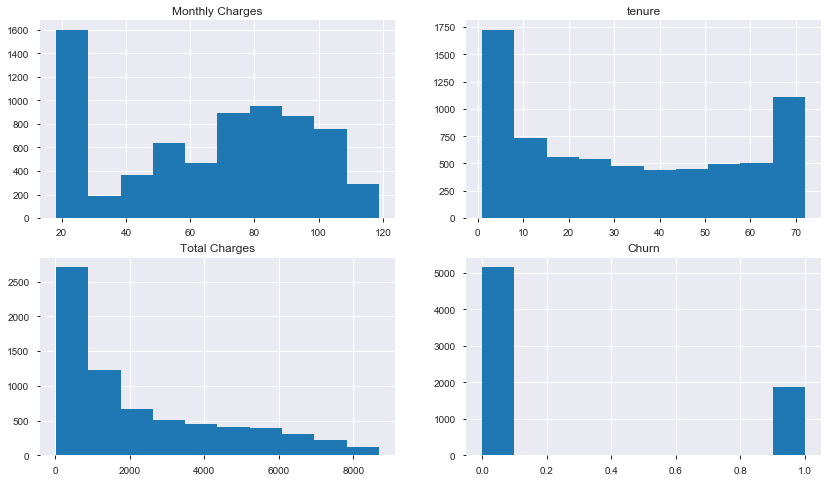

In [32]:
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

# plot the first subplot
plt.subplot(221)
plt.hist(encoded_df.monthly_charges)
plt.title('Monthly Charges')

plt.subplot(222)
plt.hist(encoded_df.tenure)
plt.title('tenure')

plt.subplot(223)
plt.hist(encoded_df.total_charges)
plt.title('Total Charges')

plt.subplot(224)
plt.hist(encoded_df.e_churn)
plt.title('Churn')

plt.show()

In [33]:
train, test = train_test_split(encoded_df, test_size=.3, random_state=123, stratify=encoded_df.e_churn)

In [34]:
# train.head()
# test.info()

X_train = train.drop(columns = ['customer_id', 'contract_type', 'e_churn'])
X_test = test.drop(columns = ['customer_id', 'contract_type', 'e_churn'])
y_train = train['e_churn']
y_test = test['e_churn']



# Graphs

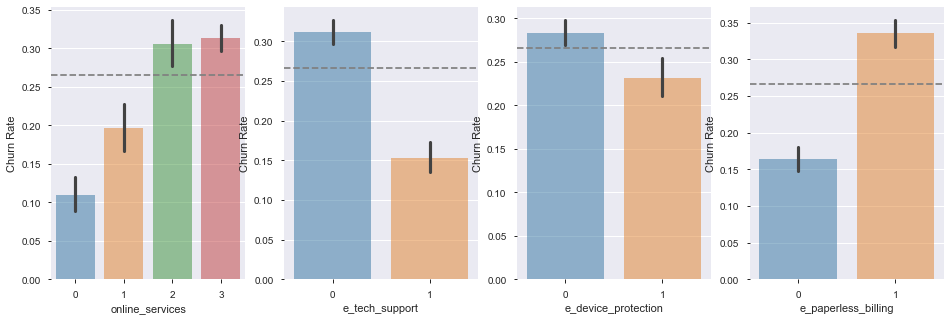

In [35]:
features = ['online_services', 'e_tech_support','e_device_protection', 'e_paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

churn_rate = encoded_df.e_churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'e_churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')


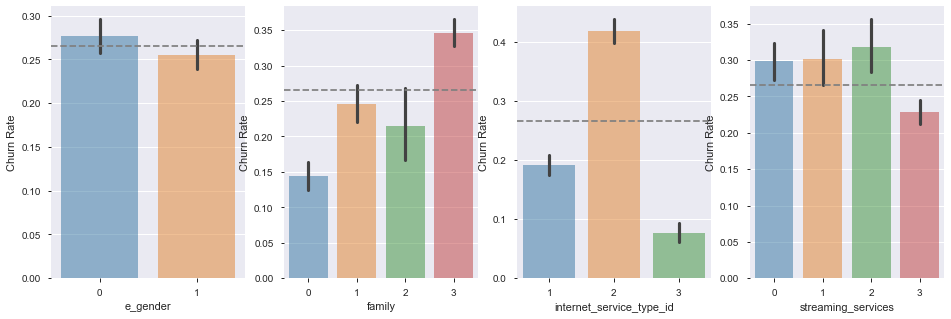

In [36]:
features = ['e_gender', 'family', 'internet_service_type_id', "streaming_services"]

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

churn_rate = encoded_df.e_churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'e_churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

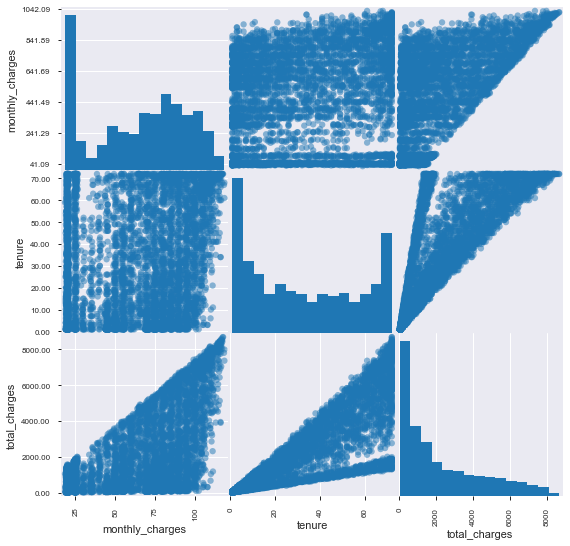

In [37]:
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

cmap = cm.get_cmap('gnuplot')
axes = pd.plotting.scatter_matrix(
    train[['monthly_charges','tenure','total_charges']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


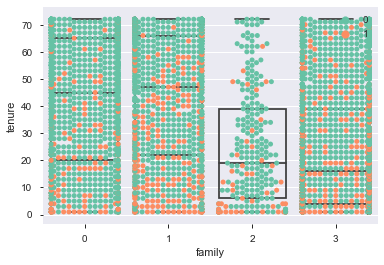

In [38]:
sns.swarmplot(x="family", y="tenure", data=train, hue="e_churn", palette="Set2")
ax = sns.boxplot(x="family", y="tenure", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})
plt.legend(loc=1)

In [39]:
pd.crosstab(train.e_gender, train.family, margins=True).style.background_gradient(cmap='YlOrRd')

family,0,1,2,3,All
e_gender,,,,,
0,630,568,96,1155,2449
1,600,575,150,1148,2473
All,1230,1143,246,2303,4922


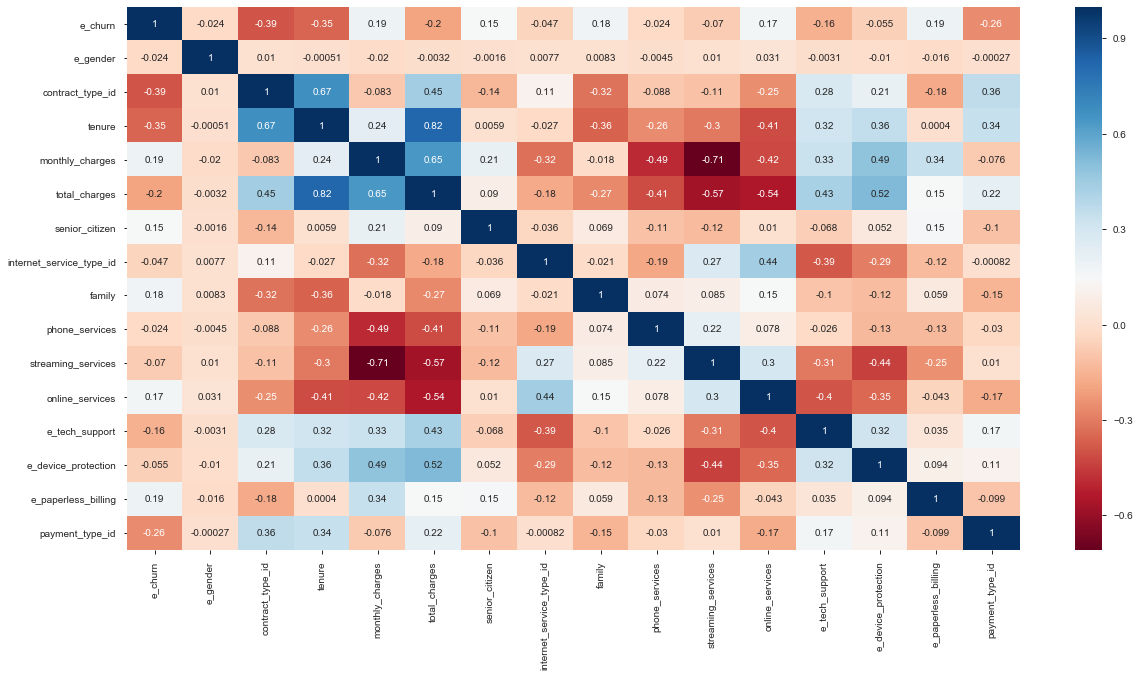

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(train.corr(), annot = True, cmap ='RdBu')



# Creating a baseline

In [41]:
numeric_X_train = X_train.drop(columns = ['e_gender', 'contract_type_id', 'streaming_services', 'online_services', 'e_tech_support', 'e_device_protection', 'e_paperless_billing','senior_citizen',
       'internet_service_type_id', 'family', 'phone_services', 'payment_type_id'])
numeric_X_test = X_test.drop(columns = ['e_gender', 'contract_type_id', 'streaming_services', 'online_services', 'e_tech_support', 'e_device_protection', 'e_paperless_billing','senior_citizen',
       'internet_service_type_id', 'family', 'phone_services', 'payment_type_id'])
y_train = train['e_churn']
y_test = test['e_churn']



In [42]:
clf = DecisionTreeClassifier(max_depth=2, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [43]:
y_pred = clf.predict(X_train)
y_pred
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
confusion_matrix(y_train, y_pred)

Accuracy of Decision Tree classifier on training set: 0.75


array([[2864,  750],
       [ 488,  820]])

In [44]:
y_train.value_counts()

0    3614
1    1308
Name: e_churn, dtype: int64

In [45]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3614
           1       0.52      0.63      0.57      1308

    accuracy                           0.75      4922
   macro avg       0.69      0.71      0.70      4922
weighted avg       0.77      0.75      0.76      4922



In [209]:
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

In [210]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.76


# Explore

Q1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

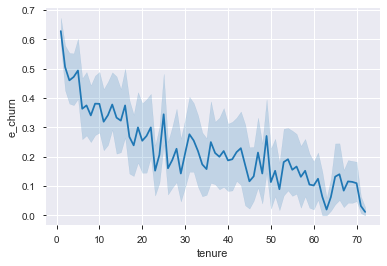

In [47]:
sns.lineplot(x="tenure", y="e_churn", data=train)
plt.show()

__Churn rates appear to be highest in the first months of tenue with an overall decrease in as tenure increases. It is not possible to say whether or not a specific sign-up month influences churn rate and is impossible to determine from the data. While intuitive to think (i.e. Christmas), it is unreasonable to consider given the data at hand.

# Q2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

# Payment Type Vs Churn Rate

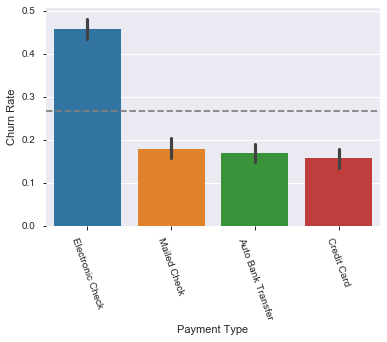

In [62]:
churn_rate = train['e_churn'].mean()

fig = sns.barplot(x="payment_type_id", y="e_churn", data=train)
fig.set_xticklabels(["Electronic Check", "Mailed Check","Auto Bank Transfer", "Credit Card"])
plt.ylabel('Churn Rate')
plt.xlabel('Payment Type')
plt.axhline(churn_rate, ls='--', color='grey')
plt.xticks(rotation=-70)
plt.show()

# Family Type Vs Churn Rate

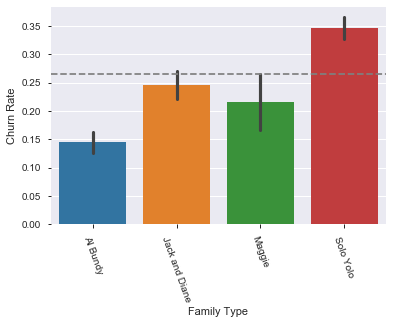

In [64]:
churn_rate = train['e_churn'].mean()

fig = sns.barplot(x="family", y='e_churn', data=train)
fig.set_xticklabels(["Al Bundy", "Jack and Diane","Maggie", "Solo Yolo"])
plt.ylabel('Churn Rate')
plt.xlabel('Family Type')
plt.axhline(churn_rate, ls='--', color='grey')
plt.xticks(rotation=-70)
plt.show()

In [65]:
train.columns

Index(['customer_id', 'e_churn', 'e_gender', 'contract_type_id',
       'contract_type', 'tenure', 'monthly_charges', 'total_charges',
       'senior_citizen', 'internet_service_type_id', 'family',
       'phone_services', 'streaming_services', 'online_services',
       'e_tech_support', 'e_device_protection', 'e_paperless_billing',
       'payment_type_id'],
      dtype='object')

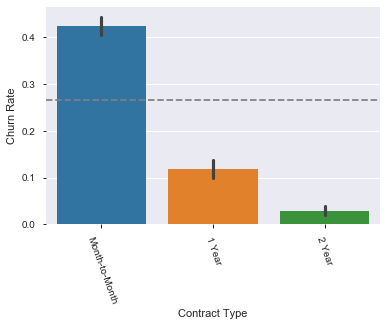

In [67]:
fig = sns.barplot(x="contract_type_id", y='e_churn', data=train)
fig.set_xticklabels(["Month-to-Month", "1 Year","2 Year"])
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.axhline(churn_rate, ls='--', color='grey')
plt.xticks(rotation=-70)
plt.show()

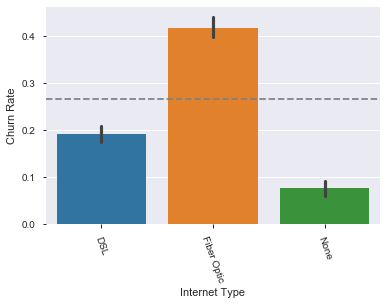

In [69]:
fig = sns.barplot(x="internet_service_type_id", y='e_churn', data=train)
fig.set_xticklabels(["DSL", "Fiber Optic","None"])
plt.ylabel('Churn Rate')
plt.xlabel('Internet Type')
plt.axhline(churn_rate, ls='--', color='grey')
plt.xticks(rotation=-70)
plt.show()

# Examining churn rates based on contract types

In [170]:
monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
priceymtm = monthtomonth[monthtomonth['monthly_charges'] > 50]
midtiermtm = monthtomonth[monthtomonth['monthly_charges'] < 50]
midtiermtm = monthtomonth[monthtomonth['monthly_charges'] >=25]
cheapmtm = monthtomonth[monthtomonth['monthly_charges'] <25]
# monthtomonth
# oneyear
# twoyear

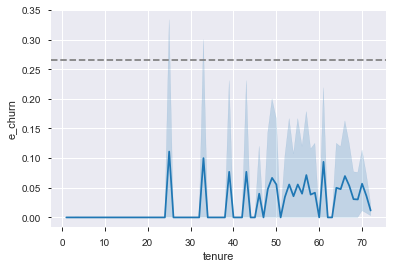

In [107]:
sns.lineplot(x="tenure", y="e_churn", data=twoyear)
plt.axhline(churn_rate, ls='--', color='grey')
plt.show()

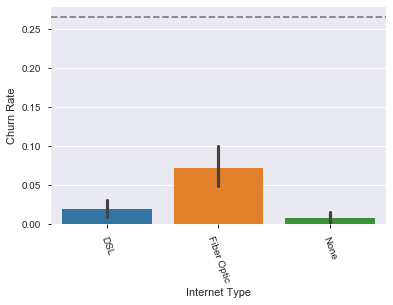

In [110]:
fig = sns.barplot(x="internet_service_type_id", y='e_churn', data=twoyear)
fig.set_xticklabels(["DSL", "Fiber Optic","None"])
plt.ylabel('Churn Rate')
plt.xlabel('Internet Type')
plt.axhline(churn_rate, ls='--', color='grey')
plt.xticks(rotation=-70)
plt.show()

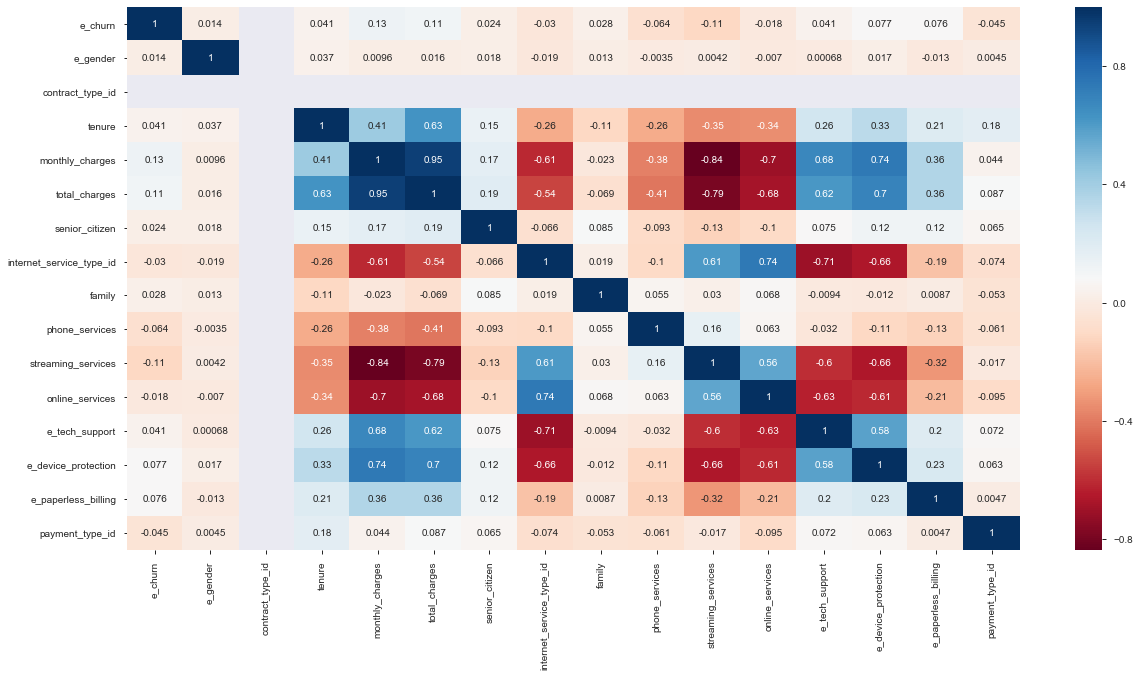

In [111]:
plt.figure(figsize=(20,10))
sns.heatmap(twoyear.corr(), annot = True, cmap ='RdBu')


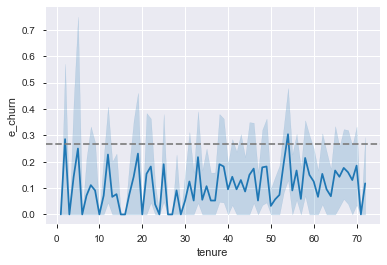

In [108]:
sns.lineplot(x="tenure", y="e_churn", data=oneyear)
plt.axhline(churn_rate, ls='--', color='grey')
plt.show()

## Month to Month Exploration

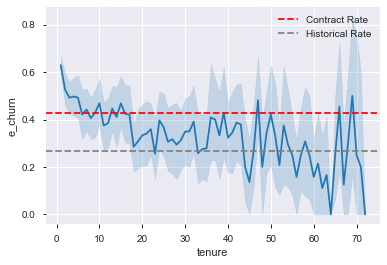

In [173]:
mtmchurn_rate = monthtomonth['e_churn'].mean()
sns.lineplot(x="tenure", y="e_churn", data=monthtomonth)

plt.axhline(mtmchurn_rate, label='Contract Rate', ls='--', color = 'red')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='grey')
plt.legend()
plt.show()

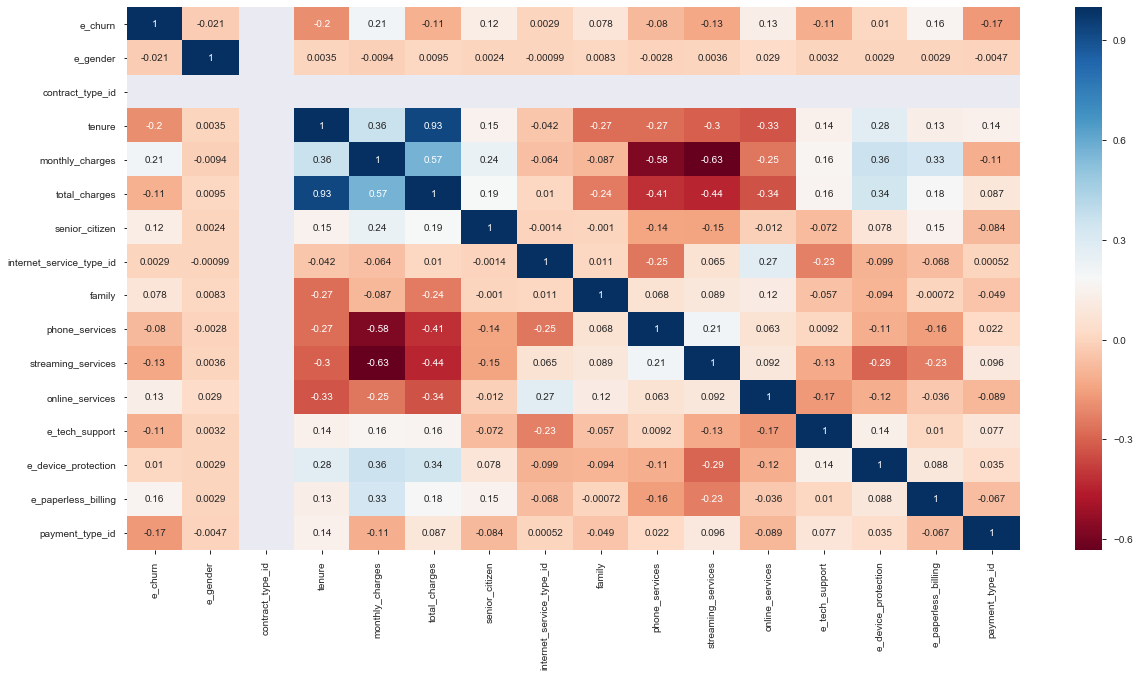

In [112]:
plt.figure(figsize=(20,10))
sns.heatmap(monthtomonth.corr(), annot = True, cmap ='RdBu')

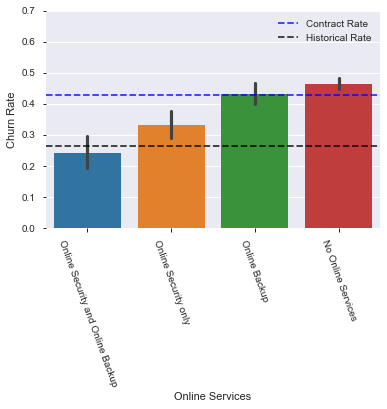

In [133]:
fig = sns.barplot(x="online_services", y='e_churn', data=monthtomonth)
fig.set_xticklabels(["Online Security and Online Backup", "Online Security only","Online Backup", 'No Online Services'])
plt.ylabel('Churn Rate')
plt.ylim(0, .7)
plt.xlabel('Online Services')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

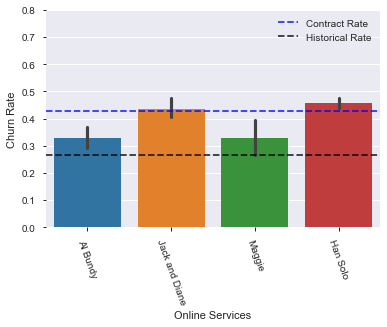

In [129]:
fig = sns.barplot(x="family", y='e_churn', data=monthtomonth)
fig.set_xticklabels(['Al Bundy', "Jack and Diane","Maggie", "Han Solo"])
plt.ylabel('Churn Rate')
plt.ylim(0, .8)
plt.xlabel('Online Services')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

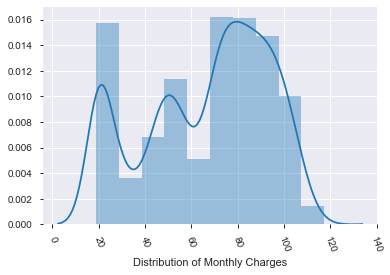

In [143]:
fig = sns.distplot(monthtomonth["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
plt.xlabel('Distribution of Monthly Charges')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

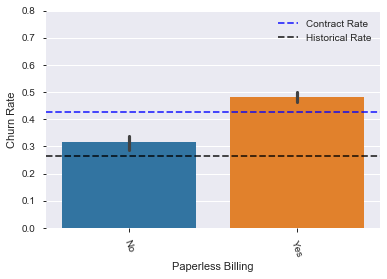

In [145]:
fig = sns.barplot(x="e_paperless_billing", y='e_churn', data=monthtomonth)
fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn Rate')
plt.ylim(0, .8)
plt.xlabel('Paperless Billing')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

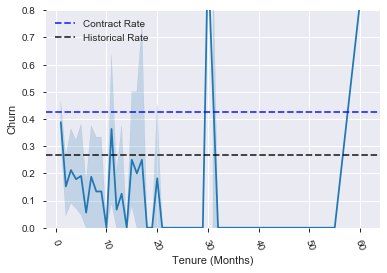

In [171]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheapmtm)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months)')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

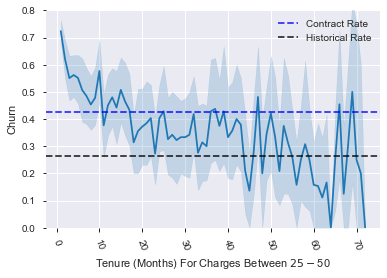

In [169]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtiermtm)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Between $25 -$50')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

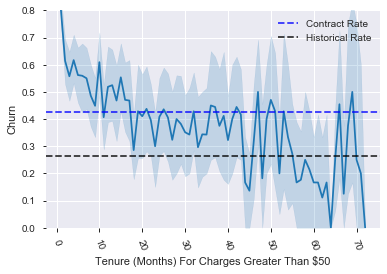

In [176]:
fig = sns.lineplot(x='tenure', y='e_churn', data=priceymtm)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Greater Than $50')
plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Month to month has a higher historical churn rate than other contracts

# 1 Year Exploration

In [177]:
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]

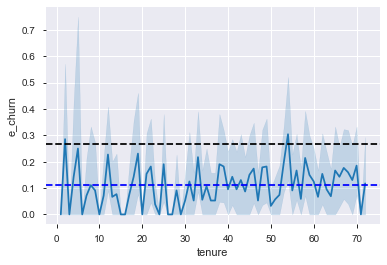

In [180]:
oneyear_rate = oneyear['e_churn'].mean()

sns.lineplot(x="tenure", y="e_churn", data=oneyear)
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='black')
plt.axhline(oneyear_rate, label = 'Contract Rate', ls='--', color='blue')
plt.show()

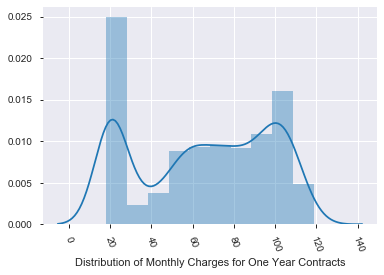

In [181]:
fig = sns.distplot(oneyear["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
plt.xlabel('Distribution of Monthly Charges for One Year Contracts')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

In [182]:
## Creating different tiers for the one year contracts

monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
pricey1year = oneyear[oneyear['monthly_charges'] >=100]
midtier1year= oneyear[oneyear['monthly_charges'] < 100]
midtier1year= oneyear[oneyear['monthly_charges'] >=40]
cheap1year = oneyear[oneyear['monthly_charges'] <40]

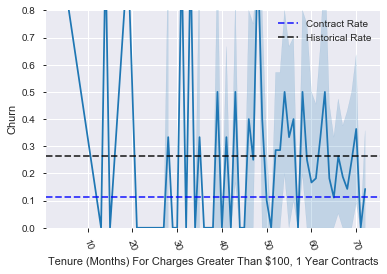

In [194]:
fig = sns.lineplot(x='tenure', y='e_churn', data=pricey1year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Greater Than $100, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

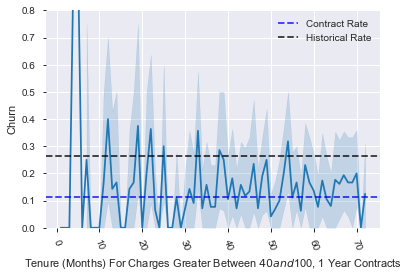

In [195]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtier1year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Greater Between $40 and $100, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

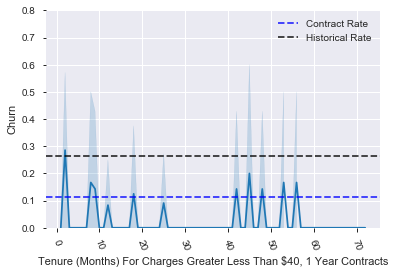

In [196]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheap1year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Greater Less Than $40, 1 Year Contracts')
plt.axhline(oneyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Conclusion:

## There is high volatility with high priced 1 year contracts that decreases as the monthly charges decreases

# Two Year Contracts

In [187]:
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]

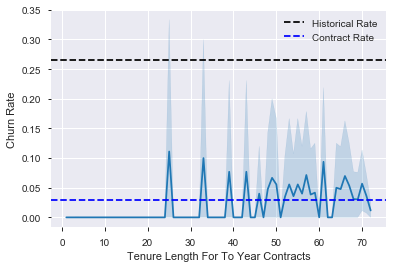

In [203]:
twoyear_rate = twoyear['e_churn'].mean()

sns.lineplot(x="tenure", y="e_churn", data=twoyear)
plt.xlabel('Tenure Length For To Year Contracts')
plt.ylabel('Churn Rate')
plt.axhline(churn_rate, label='Historical Rate', ls='--', color='black')
plt.axhline(twoyear_rate, label = 'Contract Rate', ls='--', color='blue')
plt.legend()
plt.show()

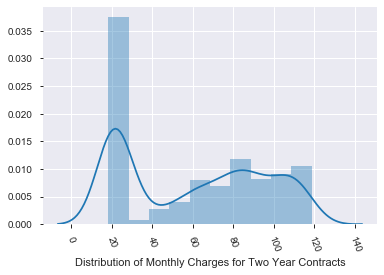

In [190]:
fig = sns.distplot(twoyear["monthly_charges"], bins = 10)
# fig.set_xticklabels([])
# plt.ylabel('Churn Rate')
plt.xlabel('Distribution of Monthly Charges for Two Year Contracts')
# plt.axhline(mtmchurn_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
# plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
# plt.legend()
plt.show()

In [191]:
monthtomonth = encoded_df[encoded_df['contract_type_id'] == 1]
oneyear = encoded_df[encoded_df['contract_type_id'] == 2]
twoyear = encoded_df[encoded_df['contract_type_id'] == 3]
pricey2year = twoyear[twoyear['monthly_charges'] >=100]
midtier2year= twoyear[twoyear['monthly_charges'] < 100]
midtier2year= twoyear[twoyear['monthly_charges'] >=40]
cheap2year = twoyear[twoyear['monthly_charges'] <40]

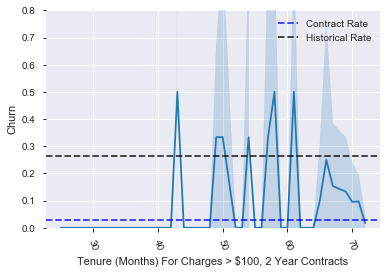

In [197]:
fig = sns.lineplot(x='tenure', y='e_churn', data=pricey2year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges > $100, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

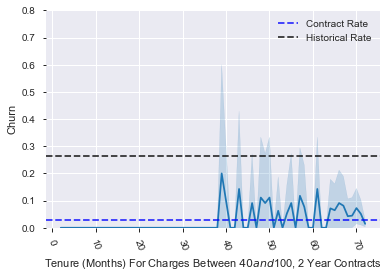

In [201]:
fig = sns.lineplot(x='tenure', y='e_churn', data=midtier2year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Between $40 and $100, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

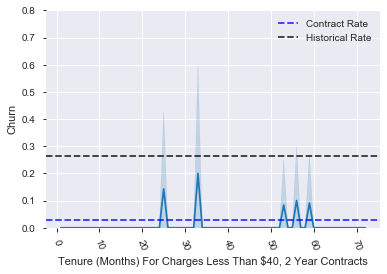

In [200]:
fig = sns.lineplot(x='tenure', y='e_churn', data=cheap2year)
# fig.set_xticklabels(['No', 'Yes'])
plt.ylabel('Churn')
plt.ylim(0, .8)
plt.xlabel('Tenure (Months) For Charges Less Than $40, 2 Year Contracts')
plt.axhline(twoyear_rate,alpha =.8, label="Contract Rate", ls='--', color = 'blue')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

# Conclusion: There is less volatility for a greater period of time. Churn rates are higher with more expensive two year contracts.

In [208]:
original_df = df.drop(columns= ['e_gender','family', 'phone_services',
       'streaming_services', 'online_services', 'e_tech_support',
       'e_device_protection', 'e_paperless_billing', 'e_churn'])
original_df.head()

,customer_id,churn,contract_type_id,contract_type,tenure,monthly_charges,total_charges,gender,partner,dependents,...,internet_service_type_id,tech_support,streaming_tv,streaming_movies,online_security,online_backup,device_protection,payment_type,payment_type_id,paperless_billing
0,0003-MKNFE,No,1,Month-to-month,9,59.9,542.40,Male,No,No,...,1,No,No,Yes,No,No,No,Mailed check,2,No
1,0013-MHZWF,No,1,Month-to-month,9,69.4,571.45,Female,No,Yes,...,1,Yes,Yes,Yes,No,No,No,Credit card (automatic),4,Yes
2,0015-UOCOJ,No,1,Month-to-month,7,48.2,340.35,Female,No,No,...,1,No,No,No,Yes,No,No,Electronic check,1,Yes
3,0023-HGHWL,Yes,1,Month-to-month,1,25.1,25.10,Male,No,No,...,1,No,No,No,No,No,No,Electronic check,1,Yes
4,0032-PGELS,Yes,1,Month-to-month,1,30.5,30.50,Female,Yes,Yes,...,1,No,No,No,Yes,No,No,Bank transfer (automatic),3,No


# Explore
Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)).

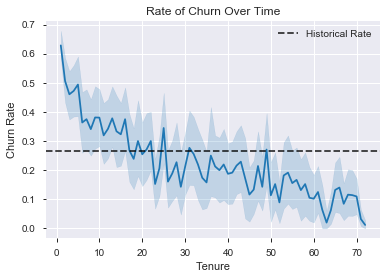

In [225]:
ax = sns.lineplot(x="tenure", y="e_churn", data=train)
ax.set(xlabel= 'Tenure', ylabel ='Churn Rate', title= 'Rate of Churn Over Time')
# plt.xlabel("Tenure Length")
# # plt.ylabel('Churn Rate')
plt.axhline(churn_rate, alpha = .8, label='Historical Rate', ls='--', color='black')
plt.legend()
plt.show()

__One cannot determine whether signing up on a particular month causes churn. Overall churn rate decreases over time.__

# Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

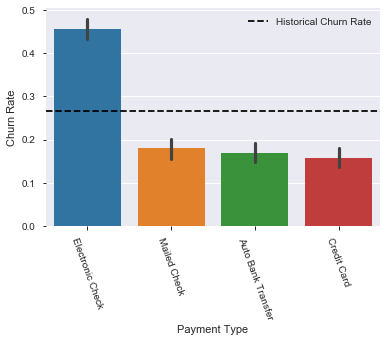

In [237]:
fig = sns.barplot(x="payment_type_id", y="e_churn", data=train)
fig.set_xticklabels(["Electronic Check", "Mailed Check","Auto Bank Transfer", "Credit Card"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Payment Type')
# plt.xlabel('Payment Type')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

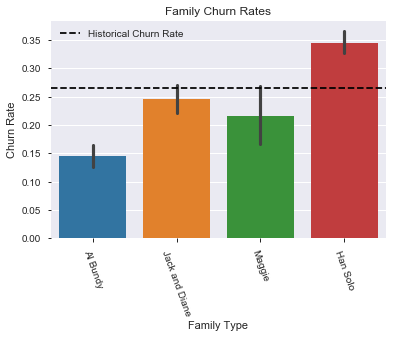

In [236]:
fig = sns.barplot(x="family", y="e_churn", data=train)
fig.set_xticklabels(['Al Bundy', "Jack and Diane","Maggie", "Han Solo"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Family Type', title = 'Family Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()

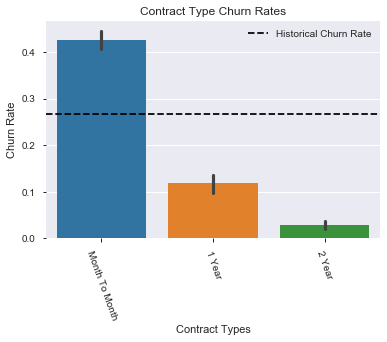

In [238]:
fig = sns.barplot(x="contract_type_id", y="e_churn", data=train)
fig.set_xticklabels(['Month To Month', "1 Year","2 Year"])
fig.set(ylabel = 'Churn Rate', xlabel = 'Contract Types', title = 'Contract Type Churn Rates')
plt.axhline(churn_rate, label = 'Historical Churn Rate', ls='--', color='black')
plt.xticks(rotation=-70)
plt.legend()
plt.show()